# Overview
In this notebook, I look into 'aligning embedding spaces'. This is a pretty broad area and so I decided to look into two specific questions. 1. Given two sets of data relating to the same source, what relationships exist and 2. Given two sets of data, set A and set B, (not neccessarily from the same source) how can we apply the same transition to each piece of data in A to get to B. I've split this notebook into two sections to answer each question as best as I can. 

## Section 1: Relationships
I will be exploring the relationships that exist between books and their summary/reviews. At the end of this section, we want to be able to explain why feature x in the reviews appears from books with feature y. For example, our model might tell us that books with simplistic plots about knights give on average positive reviews whereas sci-fi books about time travel often recieve very polarised reviews. 

### Import data and OpenAI

I am using data from the Goodreads fantasy books dataset: https://mengtingwan.github.io/data/goodreads.html. The book dataset is more of a proof of concept, since good data is hard to comeby. I have the data locally downloaded since its a very large dataset.

In [1]:
import numpy as np
import pandas as pd
import torch 
import openai
import matplotlib.pyplot as plt

In [2]:
API_KEY = "sk-proj-rFX73futiMOrVYUPKsQeT3BlbkFJb8gzZme8tWUygUFQ6Eef"
client = openai.OpenAI(api_key = API_KEY)

In [3]:
import jsonlines

books_path = r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\books\books.json'
reviews_path = r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\reviews\reviews.json'

def json_to_df(path):
    with jsonlines.open(path) as reader:
        data = [obj for obj in reader]
    return pd.DataFrame(data)

books_df = json_to_df(books_path)
reviews_df = json_to_df(reviews_path)

Quick preview of the dataset as well as the columns contained

In [4]:
print("Books df columns: ", books_df.columns.tolist())
books_df.head(3)

Books df columns:  ['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code', 'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin', 'similar_books', 'description', 'format', 'link', 'authors', 'publisher', 'num_pages', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'book_id', 'ratings_count', 'work_id', 'title', 'title_without_series']


isbn text_reviews_count     series country_code language_code  \
0                              7   [189911]           US           eng   
1  1934876569                  6   [151854]           US                 
2                             60  [1052227]           US           eng   

                                     popular_shelves        asin is_ebook  \
0  [{'count': '58', 'name': 'to-read'}, {'count':...  B00071IKUY    false   
1  [{'count': '515', 'name': 'to-read'}, {'count'...                false   
2  [{'count': '54', 'name': 'currently-reading'},...  B01NCIKAQX     true   

  average_rating kindle_asin  ... publication_month edition_information  \
0           4.03              ...                     Book Club Edition   
1           4.22              ...                 3                       
2           4.33  B01NCIKAQX  ...                                         

  publication_year                                                url  \
0             1987  https://www.goodreads.com/book/show/7327624-th...   
1             2009  https://www.goodreads.com/book/show/6066812-al...   
2                   https://www.goodreads.com/book/show/33394837-t...   

                                           image_url   book_id ratings_count  \
0  https://images.gr-assets.com/books/1304100136m...   7327624           140   
1  https://images.gr-assets.com/books/1316637798m...   6066812            98   
2  https://images.gr-assets.com/books/1493114742m...  33394837           269   

    work_id                                              title  \
0   8948723  The Unschooled Wizard (Sun Wolf and Starhawk, ...   
1    701117  All's Fairy in Love and War (Avalon: Web of Ma...   
2  54143148            The House of Memory (Pluto's Snitch #2)   

                                title_without_series  
0  The Unschooled Wizard (Sun Wolf and Starhawk, ...  
1  All's Fairy in Love and War (Avalon: Web of Ma...  
2            The House of Memory (Pluto's Snitch #2)  

[3 rows x 29 columns]

In [5]:
print("Reviews df columns: ", reviews_df.columns.tolist())
reviews_df.head(3)

Reviews df columns:  ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']


user_id   book_id  \
0  8842281e1d1347389f2ab93d60773d4d  18245960   
1  8842281e1d1347389f2ab93d60773d4d   5577844   
2  8842281e1d1347389f2ab93d60773d4d  17315048   

                          review_id  rating  \
0  dfdbb7b0eb5a7e4c26d59a937e2e5feb       5   
1  52c8ac49496c153e4a97161e36b2db55       5   
2  885c772fb033b041f42d57cef5be0a43       5   

                                         review_text  \
0  This is a special book. It started slow for ab...   
1  A beautiful story. Neil Gaiman is truly a uniq...   
2  Mark Watney is a steely-eyed missile man. A ma...   

                       date_added                    date_updated  \
0  Sun Jul 30 07:44:10 -0700 2017  Wed Aug 30 00:00:26 -0700 2017   
1  Wed Sep 24 09:29:29 -0700 2014  Wed Oct 01 00:31:56 -0700 2014   
2  Sat Apr 05 09:30:53 -0700 2014  Wed Mar 22 11:33:10 -0700 2017   

                          read_at                      started_at  n_votes  \
0  Sat Aug 26 12:05:52 -0700 2017  Tue Aug 15 13:23:18 -0700 2017       28   
1  Tue Sep 30 00:00:00 -0700 2014  Sun Sep 21 00:00:00 -0700 2014        5   
2  Mon Aug 25 00:00:00 -0700 2014  Sat Aug 16 00:00:00 -0700 2014       25   

   n_comments  
0           1  
1           1  
2           5

There are around 750,000 books in this dataset. As I don't want to rate limit openAI and speed up research, I am only going to consider 1,000 books and 5 reviews from each book. I'm also going to filter out any smaller length reviews.

In [175]:
def filter_books_and_reviews(books_df: pd.DataFrame, reviews_df: pd.DataFrame, min_review_count: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    reviews_df_filtered = reviews_df[reviews_df['review_text'].str.len() >= 100]
    merged_df = pd.merge(books_df, reviews_df_filtered, on='book_id', how='inner')
    review_counts = merged_df.groupby('book_id').size()
    valid_books = review_counts[review_counts >= min_review_count].index
    filtered_books_df = books_df[books_df['book_id'].isin(valid_books)]
    filtered_reviews_df = reviews_df_filtered[reviews_df_filtered['book_id'].isin(valid_books)]

    return filtered_books_df, filtered_reviews_df

min_review_count = 50
books_result_df, reviews_result_df = filter_books_and_reviews(books_df, reviews_df, min_review_count)

print("Books:", books_result_df.shape[0])
print("Reviews:", reviews_result_df.shape[0])

Books: 7327
Reviews: 1585061


In [176]:
def sample_books_and_reviews(books_df: pd.DataFrame, reviews_df: pd.DataFrame, n: int, m: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    sampled_books_df = books_df.sample(n=n, random_state=42)  # Set random_state for reproducibility
    sampled_book_ids = sampled_books_df['book_id']
    sampled_reviews_df = reviews_df[reviews_df['book_id'].isin(sampled_book_ids)]
    grouped_reviews = sampled_reviews_df.groupby('book_id', group_keys=False)
    limited_reviews_df = grouped_reviews.apply(lambda x: x.head(m)).reset_index(drop=True)
    return sampled_books_df, limited_reviews_df
    
sampled_books_df, sampled_reviews_df = sample_books_and_reviews(books_result_df, reviews_result_df, 1000, 5)
print("Books:", sampled_books_df.shape[0])
print("Reviews:", sampled_reviews_df.shape[0])

C:\Users\Jasam\AppData\Local\Temp\ipykernel_14232\3800706530.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  limited_reviews_df = grouped_reviews.apply(lambda x: x.head(m)).reset_index(drop=True)


Books: 1000
Reviews: 5000


In [177]:
sampled_books_df.head()

isbn text_reviews_count                     series country_code  \
112190  0515152854                255           [493488, 435759]           US   
53096   1592220053                376                         []           US   
158262  1606904388                216  [545553, 903272, 1014676]           US   
133092  1407129856                343                         []           US   
131927  174166134X                947                   [170906]           US   

       language_code                                    popular_shelves asin  \
112190           eng  [{'count': '1121', 'name': 'to-read'}, {'count...        
53096                 [{'count': '2845', 'name': 'to-read'}, {'count...        
158262           eng  [{'count': '2850', 'name': 'to-read'}, {'count...        
133092         en-GB  [{'count': '26703', 'name': 'to-read'}, {'coun...        
131927           eng  [{'count': '8331', 'name': 'to-read'}, {'count...        

       is_ebook average_rating kindle_asin  ... publication_month  \
112190    false           4.10  B00BDQ3B7O  ...                 8   
53096     false           4.08  B0092EE5HY  ...                10   
158262    false           3.90  B00GOZ2I6Y  ...                11   
133092    false           4.08  B0051WIX24  ...                10   
131927    false           4.33  B002IEUV32  ...                 8   

       edition_information publication_year  \
112190                                 2013   
53096                                  2004   
158262                                 2013   
133092                                 2011   
131927                                 2006   

                                                      url  \
112190  https://www.goodreads.com/book/show/15810877-d...   
53096   https://www.goodreads.com/book/show/776212.Tuf...   
158262  https://www.goodreads.com/book/show/18430203-j...   
133092  https://www.goodreads.com/book/show/11210739-t...   
131927  https://www.goodreads.com/book/show/1814843.Th...   

                                                image_url   book_id  \
112190  https://images.gr-assets.com/books/1365940062m...  15810877   
53096   https://s.gr-assets.com/assets/nophoto/book/11...    776212   
158262  https://s.gr-assets.com/assets/nophoto/book/11...  18430203   
133092  https://images.gr-assets.com/books/1327355206m...  11210739   
131927  https://images.gr-assets.com/books/1327445821m...   1814843   

       ratings_count   work_id  \
112190          2850  21536022   
53096           4661    925829   
158262          1816  26071782   
133092          1137  15535056   
131927         38554   6627899   

                                                    title  \
112190  Deception Cove (Rainshadow, #2; Ghost Hunters,...   
53096                                        Tuf Voyaging   
158262          Jim Butcher's Dresden Files: Ghoul Goblin   
133092                                  The Scorpio Races   
131927    The Siege of Macindaw (Ranger's Apprentice, #6)   

                                     title_without_series  
112190  Deception Cove (Rainshadow, #2; Ghost Hunters,...  
53096                                        Tuf Voyaging  
158262          Jim Butcher's Dresden Files: Ghoul Goblin  
133092                                  The Scorpio Races  
131927    The Siege of Macindaw (Ranger's Apprentice, #6)  

[5 rows x 29 columns]

Now that we have our book data, we can genereate embeddings from the strings of each row in the dataframe

In [178]:
embed_model = 'text-embedding-3-small'
def get_embeddings(texts: list[str], batch_size: int = 500, verbose=False) -> list[np.ndarray]:
    embeddings = []
    for i in range(0, len(texts), batch_size):
        if verbose: print(f"Generating embedding {i}/{len(texts)}")
        batch = texts[i:i + batch_size]
        response = client.embeddings.create(input=batch, model=embed_model)
        batch_embeddings = [np.array(embedding.embedding) for embedding in response.data]
        embeddings.extend(batch_embeddings)
    return embeddings

In [179]:
def strings_from_df(df: pd.DataFrame, columns=None, preamble="") -> list[list[str]]:
    if not(columns): columns = df.columns
    row_strings = []
    for _, row in df.iterrows():
        row_string_list = [f"{col}: {row[col]}" for col in columns]
        row_strings.append((preamble + "|".join(row_string_list))[:10000])
    return row_strings

In [184]:
books_strings = strings_from_df(sampled_books_df, preamble="This is a SUMMARY of a book: ")
reviews_strings = strings_from_df(sampled_reviews_df, preamble="This is a REVIEW of a book: ")

In [185]:
books_embeds = get_embeddings(books_strings, batch_size=500, verbose=True)
reviews_embeds = get_embeddings(reviews_strings, batch_size=500, verbose=True)

Generating embedding 0/1000
Generating embedding 500/1000
Generating embedding 0/5000
Generating embedding 500/5000
Generating embedding 1000/5000
Generating embedding 1500/5000
Generating embedding 2000/5000
Generating embedding 2500/5000
Generating embedding 3000/5000
Generating embedding 3500/5000
Generating embedding 4000/5000
Generating embedding 4500/5000


In [186]:
sampled_books_df['embedding'] = books_embeds
sampled_reviews_df['embedding'] = reviews_embeds

I saved the embeddings to a local file to speed up development

In [183]:
import pickle

with open(r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\books\sampled_books_df.pkl', 'wb') as file:
        pickle.dump(sampled_books_df, file)

with open(r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\reviews\sampled_reviews_df.pkl', 'wb') as file:
        pickle.dump(sampled_reviews_df, file)

In [187]:
import pickle 

books_df_file = open(r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\books\sampled_books_df.pkl','rb')
sampled_books_df = pickle.load(books_df_file)
books_df_file.close()

reviews_df_file = open(r'C:\Users\Jasam\Desktop\Pytorch Test\goodreads-data\reviews\sampled_reviews_df.pkl','rb')
sampled_reviews_df = pickle.load(reviews_df_file)
reviews_df_file.close()

books_embeds = sampled_books_df['embedding'].tolist()
reviews_embeds = sampled_reviews_df['embedding'].tolist()

### Visualise data
Now that we have the embeddings, let's visualise them to better understand what features they share. A good of visualising the embeddings is to display them as an image by reshaping the vector. Taking a look at the array of embeddings, we see that they share a lot of similair features. This makes sense as they are all book summaries, however this means that a lot of the embedding dimensions are being wasted.

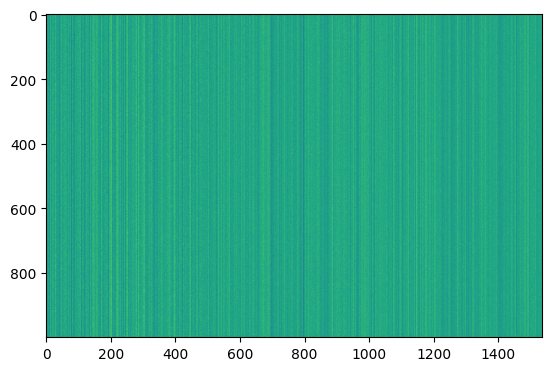

In [188]:
plt.imshow(np.array(books_embeds))

A closer look at books of different genre's reveals that only a handful of dimensions matter when differentiating high-ish level features. If we scale our data such that each dimension is normally distributed we end up with much richer embeddings, however it becomes harder to differentiate dimensions that hold more weight.


In [189]:
def clean_genres(genres): return [genre['name'] for genre in genres if int(genre['count']) > 10]
sampled_books_df['popular_shelves'] = sampled_books_df['popular_shelves'].apply(clean_genres)

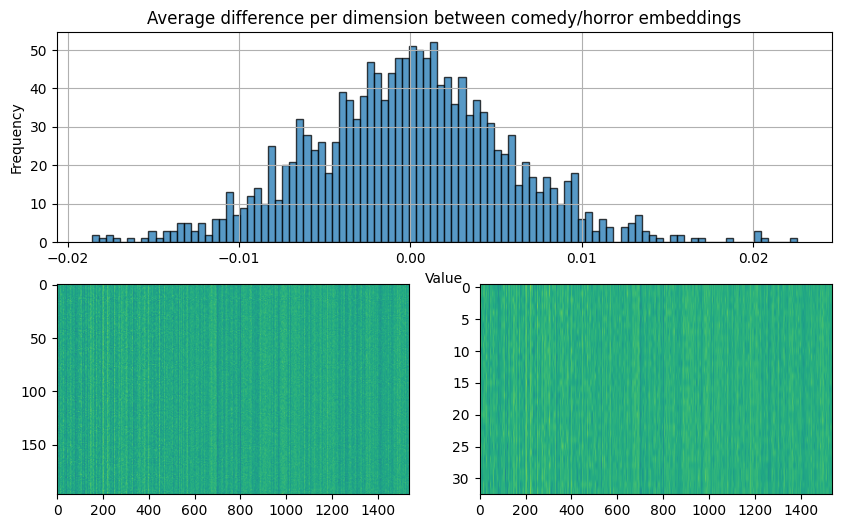

In [190]:
def get_genre(df, genre_name):
    return df[df['popular_shelves'].apply(lambda x: genre_name in x)]

horror_ex = get_genre(sampled_books_df, 'horror')
comedy_ex = get_genre(sampled_books_df, 'comedy')

horror_embeds = np.array(horror_ex['embedding'].tolist())
comedy_embeds = np.array(comedy_ex['embedding'].tolist())

av_diff = np.mean(horror_embeds, axis=0).reshape(1536,1) - np.mean(comedy_embeds, axis=0).reshape(1536,1)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.subplot(2,1,1)
plt.hist(av_diff, bins=100, alpha=0.75, edgecolor='black')
plt.title('Average difference per dimension between comedy/horror embeddings')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(2,2,3)
plt.imshow(horror_embeds, aspect='auto')
plt.subplot(2,2,4)
plt.imshow(comedy_embeds, aspect='auto')
plt.show()

Above you can see, that it is very hard to notice what differentiates the horror embeddings from the comedy embeddings. One would think this should be easy? 

Even clustering the data using K-means does not produce any meaningful seperations beetween the embeddings because of how similair they all are. As a result we need to find a way to really highlight the differences between the vectors and make use of the embeddings.

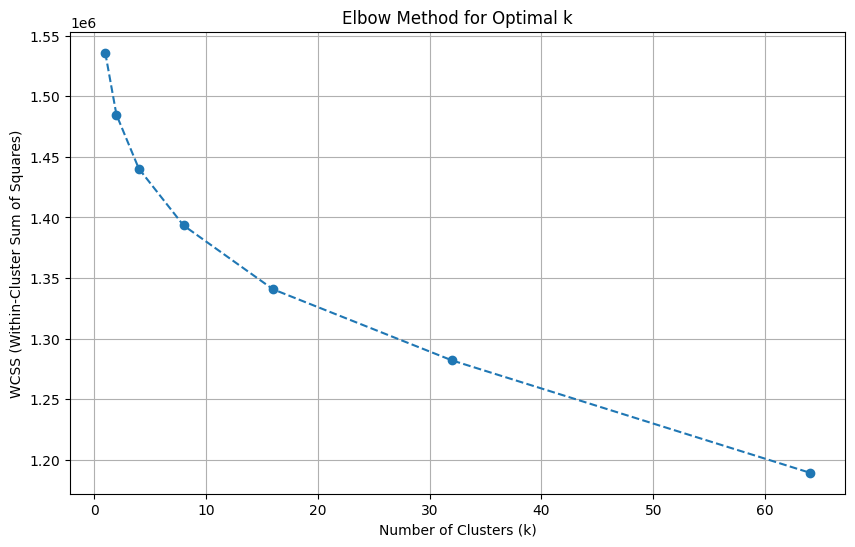

In [403]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.array(books_embeds))

k_values = [1,2,4,8,16,32,64]
scaled_wcss = []

for k in k_values:
    scaled_kmeans = KMeans(n_clusters=k, random_state=42)
    scaled_kmeans.fit(scaled_data)
    scaled_wcss.append(scaled_kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, scaled_wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

k=16 seems like a good value to use. Let's view the clusters.

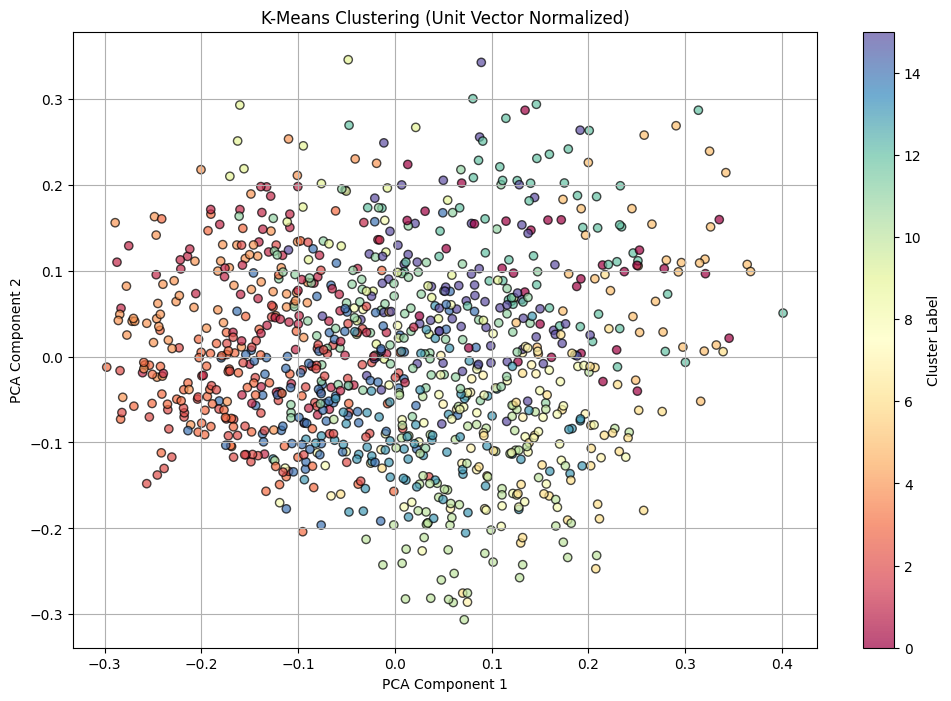

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_clusters(data, labels, title):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral', alpha=0.7, edgecolor='k')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    plt.show()

def cluster_and_plot(df):
    embeddings = np.array(df["embedding"].tolist())
    
    k = 16
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    embeddings_normalized = normalize(embeddings, norm='l2')
    pca = PCA(n_components = 2) 
    pca_normalized = pca.fit_transform(embeddings_normalized)
    kmeans.fit(embeddings_normalized)
    labels_normalized = kmeans.labels_
    plot_clusters(pca_normalized, labels_normalized, 'K-Means Clustering (Unit Vector Normalized)')
    return labels_normalized

labels_normalised = cluster_and_plot(sampled_books_df)

Since the embedding model isn't specialised, the output is more noisy and cluster is mediocre. We will attempt to produce more descriptive dense embeddings by using normalisation and auto-encoders.

### Autoencoders
To analyse "important" relationships between the data, we are going to be creating denser encoded versions of the embeddings, in the hopes that each dimension will represent a tangible aspect of a book/review unlike the fine but unspecialised embeddings that ChatGPT creates. We can think of this as specialising the embeddings to the domain of books. Once we have a well trained auto encoder, we can use statistical analysis techniques on the encodings to work out which dense dimensions are related. From this we will reverse engineer which dense dimensions are related to which input/output dimensions. Of course the input/output dimensions are just ChatGPT dimensions from the original encodings. These input/output dimensions will form an axis along the embedding space. From there, we can see how the original texts vary across this access by using the related embeddings. With NLP this should give us an insight into some kind of relationship.

In [194]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [195]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim)#,
            #nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

In [196]:
def train_autoencoder(autoencoder, data, epochs=100, batch_size=32, learning_rate=1e-3, verbose=False):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    loss_values = []
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            batch = batch[0]
            optimizer.zero_grad()
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        average_loss = total_loss / len(data_loader)
        loss_values.append(average_loss)
        if verbose: print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}')
    
    return loss_values

In [197]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

def mini_train(dataset, input_dim, hidden_dim):
    autoencoder: Autoencoder = Autoencoder(input_dim, hidden_dim)
    auto_loss: list[float] = train_autoencoder(autoencoder, dataset, epochs=100, batch_size=32, learning_rate=1e-3)
    return autoencoder, auto_loss

def standardise(data):
    s = StandardScaler()
    return s.fit_transform(np.array(data))

def create_dataset(embeds):
    std_embeds = standardise(embeds)
    tensor_data = torch.tensor(std_embeds, dtype=torch.float32)
    return TensorDataset(tensor_data)

books_dataset = create_dataset(books_embeds)
books_models = []
books_auto_losses = []

reviews_dataset = create_dataset(reviews_embeds)
reviews_models = []
reviews_auto_losses = []

input_dim = 1536
hidden_dims = [8,16,32,64]

for hidden_dim in hidden_dims:
    print(f"Training autoencoders with dim {hidden_dim}")
    
    books_auto, books_auto_loss = mini_train(books_dataset, input_dim, hidden_dim)
    reviews_auto, reviews_auto_loss = mini_train(reviews_dataset, input_dim, hidden_dim)
    
    books_models.append(books_auto)
    books_auto_losses.append(books_auto_loss)

    reviews_models.append(reviews_auto)
    reviews_auto_losses.append(reviews_auto_loss)

Running on cuda
Training autoencoders with dim 8
Training autoencoders with dim 16
Training autoencoders with dim 32
Training autoencoders with dim 64


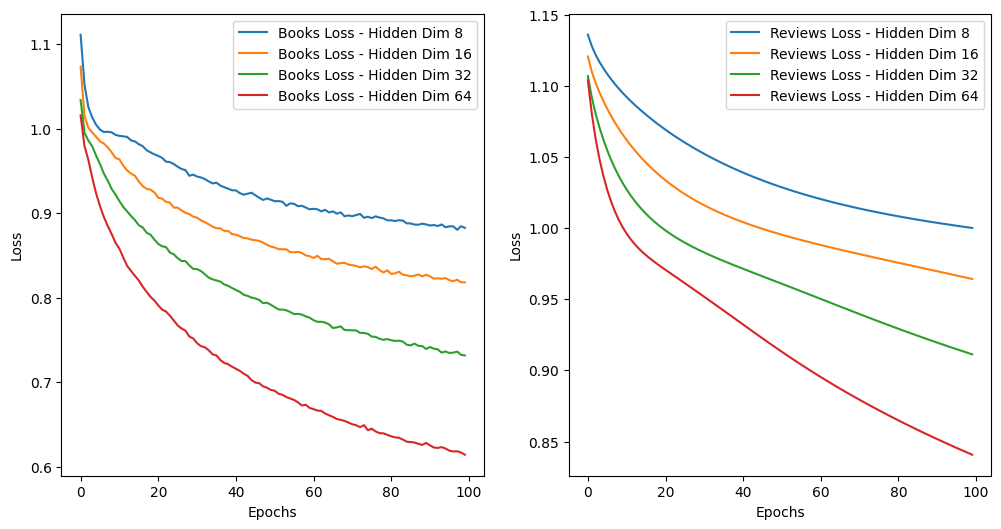

In [26]:
plt.figure(figsize=(12,6))
for i, hidden_dim in enumerate(hidden_dims):
    plt.subplot(1,2,1)
    plt.plot(books_auto_losses[i], label=f'Books Loss - Hidden Dim {hidden_dim}')
    plt.subplot(1,2,2)
    plt.plot(reviews_auto_losses[i], label=f'Reviews Loss - Hidden Dim {hidden_dim}')    

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.show()

Taking a look at the encodings produced below we see that the embeddings are a lot more dense and hopefully richer in meaning. We can also take a look at any singular row and see that the encodings do a pretty good job at reconstructing the original data.

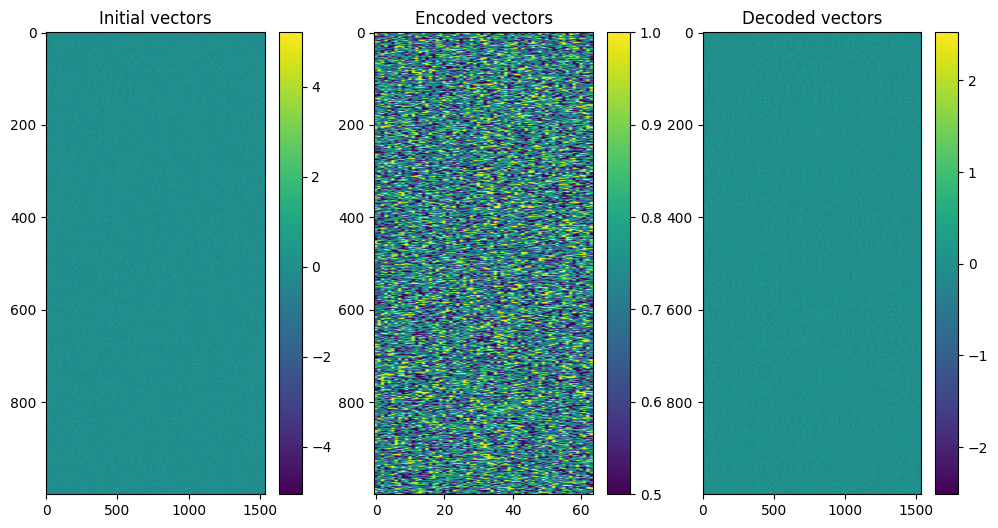

In [198]:
books_model = books_models[3]

ivecs = [books_dataset[ind][0] for ind in range(1000)]
evecs = [books_model.encode(ivec) for ivec in ivecs]
dvecs = [books_model.decode(evec) for evec in evecs]

evecs = np.array([evec.detach().numpy() for evec in evecs])
dvecs = np.array([dvec.detach().numpy() for dvec in dvecs])

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(ivecs, aspect='auto')
plt.colorbar()
plt.title('Initial vectors')

plt.subplot(1, 3, 2)
plt.imshow(evecs, aspect='auto')
plt.colorbar()
plt.title('Encoded vectors')

plt.subplot(1, 3, 3)
plt.imshow(dvecs, aspect='auto')
plt.colorbar()
plt.title('Decoded vectors')
plt.show()

Let's compare the horror embeddings to the comedy embeddings now, using the encodings.

In [199]:
books_model = books_models[3]
books_enc = [books_model.encode(ivec).detach().numpy() for ivec in [books_dataset[ind][0] for ind in range(1000)]]
books_enc = np.array(books_enc)

reviews_model = reviews_models[3]
reviews_enc = [reviews_model.encode(ivec).detach().numpy() for ivec in [reviews_dataset[ind][0] for ind in range(1000 * 5)]]
reviews_enc = np.array(reviews_enc)

sampled_books_df['encoding'] = books_enc.tolist()
sampled_reviews_df['encoding'] = reviews_enc.tolist()

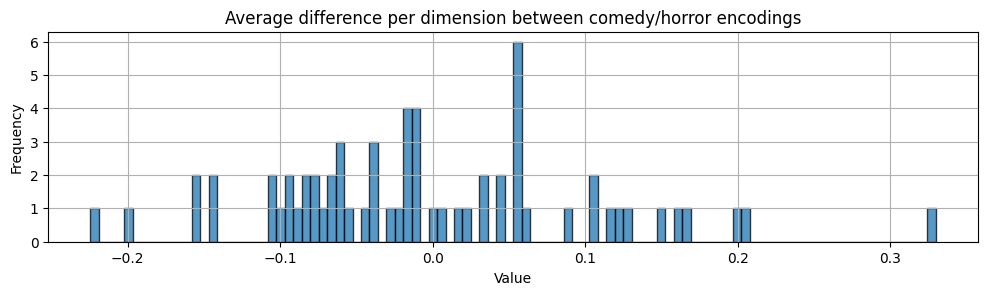

In [200]:
horror_ex = get_genre(sampled_books_df, 'horror')[:32]
comedy_ex = get_genre(sampled_books_df, 'comedy')[:32]

horror_enc = np.array(horror_ex['encoding'].tolist())
comedy_enc = np.array(comedy_ex['encoding'].tolist())

av_diff = np.mean(horror_enc, axis=0).reshape(64,1) - np.mean(comedy_enc, axis=0).reshape(64,1)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.hist(av_diff, bins=100, alpha=0.75, edgecolor='black')
plt.title('Average difference per dimension between comedy/horror encodings')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

On average the difference between the horror/comedy encodings are larger than before, meaning that the encodings have specialised successfully. We can now run a correlation test on the book encodings and the review encodings.

### Correlation
We will generate a correlation matrix for the book and review encodings. Using this matrix we can figure out which dimensions are tied together in the encoding space. From these relationships we can find the relevant input/output dimensions affected on the books/reviews end. 

To get the correlation matrix, we will glue the book and review encodings together into one matrix. This will allow us to get some sense of correlation.

In [201]:
merged_df = sampled_reviews_df.merge(sampled_books_df[['book_id', 'embedding', 'encoding']], on='book_id', suffixes=('_reviews', '_books'))
merged_df.head()

user_id   book_id  \
0  43d9d14507354d4d3b1861d48762c22b  10050463   
1  f7b3aa36aa4f0a7c6d3295eb6d9dde91  10050463   
2  076f0541935a2894258c39bd1101495e  10050463   
3  3f6a4d5e743192ebcc7222c0b566ef73  10050463   
4  0d958a941e97b81893c56094c025d28b  10050463   

                          review_id  rating  \
0  8e892ed86fc616f977a803541d6b01ce       5   
1  7df27825cef902397e21f9ac67e74729       5   
2  059662c511cdee6266091a1e1f3e6683       5   
3  48783570493077053236568ebf6aaefd       5   
4  2f42faeffab0903ab46f1bf58a0cb496       5   

                                         review_text  \
0  Okay so I have alot of feels about this book a...   
1  Zur Aufmachung \n Joah, die amerikanischen Cov...   
2  OMG I can't describe what I'm feeling right no...   
3  Brilliant, Magnus continues to be one of my fa...   
4  Let me just bask in the awesomeness of this bo...   

                       date_added                    date_updated  \
0  Wed Nov 19 14:19:44 -0800 2014  Sat Dec 20 10:35:15 -0800 2014   
1  Tue Jul 31 14:44:47 -0700 2012  Sat Jan 14 15:46:23 -0800 2017   
2  Tue Jan 22 09:07:01 -0800 2013  Sat Jun 22 06:17:06 -0700 2013   
3  Thu Apr 11 08:50:17 -0700 2013  Tue Jul 02 08:15:56 -0700 2013   
4  Sun Mar 03 16:49:42 -0800 2013  Sat Mar 16 22:16:32 -0700 2013   

                          read_at                      started_at  n_votes  \
0  Sat Nov 29 05:42:14 -0800 2014  Wed Nov 19 00:00:00 -0800 2014        1   
1  Sun Jan 01 00:00:00 -0800 2012                                        1   
2  Sat Jun 22 06:17:06 -0700 2013  Tue Jun 18 00:00:00 -0700 2013        0   
3  Tue Jul 02 08:15:56 -0700 2013  Thu Jun 27 00:00:00 -0700 2013        0   
4  Sun Mar 17 22:16:32 -0700 2013  Fri Mar 15 00:00:00 -0700 2013        0   

   n_comments                                  embedding_reviews  \
0           6  [0.03344384953379631, 0.05510508641600609, -0....   
1           0  [0.019186783581972122, 0.051435891538858414, -...   
2           0  [-0.012675750069320202, 0.06109774857759476, -...   
3           0  [-0.019279131665825844, 0.07272078841924667, -...   
4           0  [0.008224857971072197, 0.037438131868839264, -...   

                                    encoding_reviews  \
0  [0.9688883423805237, 0.5, 0.9486241936683655, ...   
1  [0.9073358774185181, 0.5691363215446472, 0.994...   
2  [0.781140148639679, 0.9453884959220886, 0.9909...   
3  [0.8567737936973572, 0.9398546814918518, 0.977...   
4  [0.949688732624054, 0.8226009607315063, 0.9656...   

                                     embedding_books  \
0  [-0.005664469674229622, 0.06887386739253998, -...   
1  [-0.005664469674229622, 0.06887386739253998, -...   
2  [-0.005664469674229622, 0.06887386739253998, -...   
3  [-0.005664469674229622, 0.06887386739253998, -...   
4  [-0.005664469674229622, 0.06887386739253998, -...   

                                      encoding_books  
0  [0.9063595533370972, 0.9999803304672241, 0.989...  
1  [0.9063595533370972, 0.9999803304672241, 0.989...  
2  [0.9063595533370972, 0.9999803304672241, 0.989...  
3  [0.9063595533370972, 0.9999803304672241, 0.989...  
4  [0.9063595533370972, 0.9999803304672241, 0.989...

(128, 128)


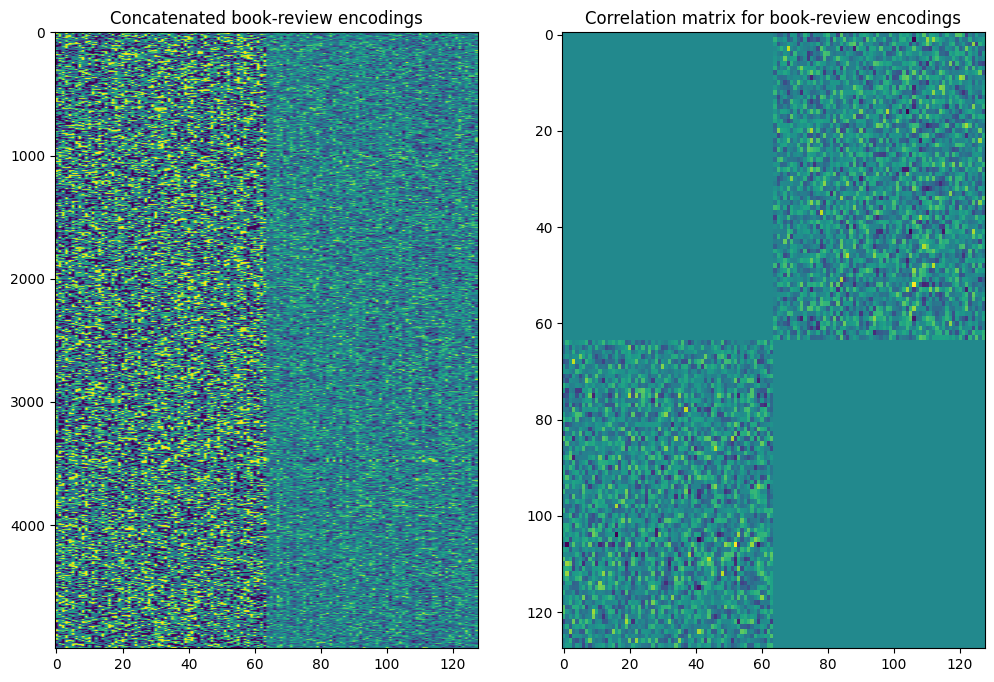

In [202]:
merged_book_enc = np.array(merged_df['encoding_books'].tolist())
merged_reviews_enc = np.array(merged_df['encoding_reviews'].tolist())
merged_enc = np.concatenate((merged_book_enc, merged_reviews_enc), axis=1)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.title("Concatenated book-review encodings")
plt.imshow(merged_enc, aspect='auto')

corr_mat = np.corrcoef(merged_enc, rowvar=False)
print(corr_mat.shape)
corr_mat[:64,:64] = 0
corr_mat[64:,64:] = 0
plt.subplot(1,2,2)
plt.title("Correlation matrix for book-review encodings")
plt.imshow(corr_mat, aspect='auto')
plt.show()

In [203]:
corr_dict = {(i,j): corr_mat[i,j] for i in range(0,64) for j in range(64,128)}
sorted_corrs = sorted(corr_dict, key=lambda k: abs(corr_dict[k]))

By sorting for the most correlated variables, we have identified the strongest relationships in the dense encodings. Now we will prod the auto-encoder to find out which input/output dimensions these features relate to. Also bear in mind that because the encodings are so dense, we don't expect high correlation between them.

[]

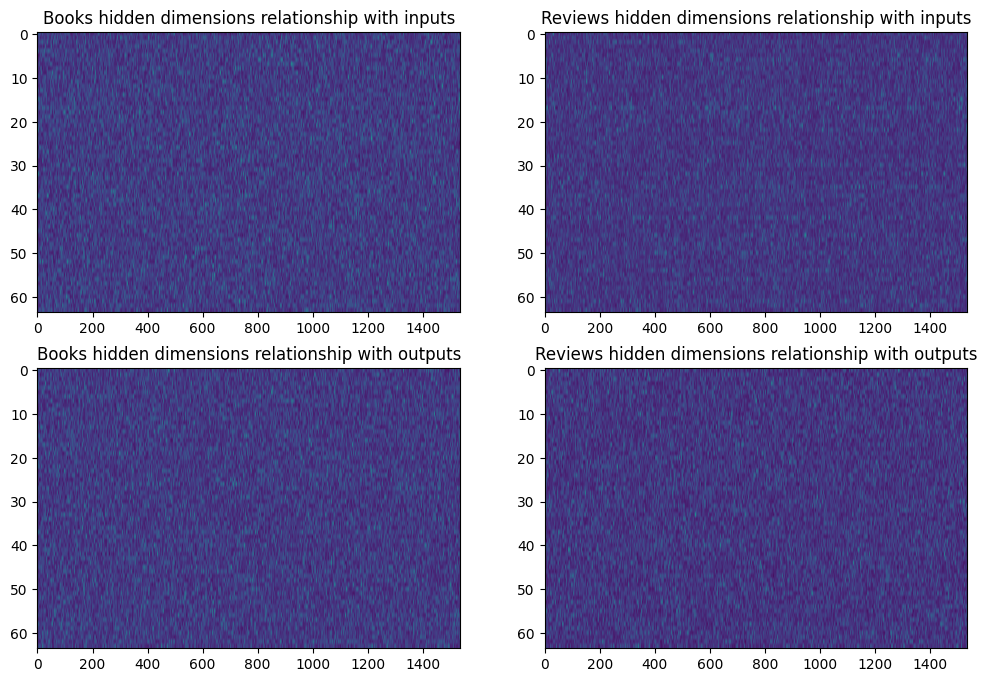

In [205]:
def keep_n_highest(array, n):
    flat_array = array.flatten()
    top_indices = np.argpartition(flat_array, -n)[-n:]
    mask = np.zeros_like(flat_array, dtype=bool)
    mask[top_indices] = True
    result_array = np.where(mask, flat_array, 0)
    result_array = result_array.reshape(array.shape)
    return result_array

def get_crit_weights(model, n):
    enc_weights = model.encoder[0].weight.detach().numpy()
    dec_weights = model.decoder[0].weight.detach().numpy().T
    enc_crit = [keep_n_highest(w, n) for w in enc_weights]
    dec_crit = [keep_n_highest(w, n) for w in dec_weights]
    return (enc_crit, dec_crit)


plt.figure(figsize=(12,8))
top_n_weights = 1000

books_model = books_models[3]
books_enc_crit, books_dec_crit = get_crit_weights(books_model, top_n_weights)

reviews_model = reviews_models[3]
reviews_enc_crit, reviews_dec_crit = get_crit_weights(reviews_model, top_n_weights)

plt.subplot(2,2,1)
plt.title("Books hidden dimensions relationship with inputs")
plt.imshow(books_enc_crit[:], aspect='auto')
plt.plot()

plt.subplot(2,2,3)
plt.title("Books hidden dimensions relationship with outputs")
plt.imshow(books_dec_crit[:], aspect='auto')
plt.plot()

plt.subplot(2,2,2)
plt.title("Reviews hidden dimensions relationship with inputs")
plt.imshow(reviews_enc_crit[:], aspect='auto')
plt.plot()

plt.subplot(2,2,4)
plt.title("Reviews hidden dimensions relationship with outputs")
plt.imshow(reviews_dec_crit[:], aspect='auto')
plt.plot()


We can generate unit vectors in the directions of interest in the input/output dimensions. Then we compute the cosine distance of each embedding using these unit vectors. With NLP we can figure out what moving along this dimension roughly means in terms of book summaries or reviews. This gives us our final relationships at the end.

In [365]:
def cosine_similarity_matrix(embeddings, unit_vector):
    embeddings_array = np.array(embeddings)
    dot_products = np.dot(embeddings_array, unit_vector)
    norms = np.linalg.norm(embeddings_array, axis=1)
    cosine_similarities = dot_products / norms
    return cosine_similarities

In [366]:
def l2norm(data):
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    return np.divide(data, norms, where=(norms!=0))

books_enc_crit_norm = l2norm(books_enc_crit)
books_dec_crit_norm = l2norm(books_dec_crit)
reviews_enc_crit_norm = l2norm(reviews_enc_crit)
reviews_dec_crit_norm = l2norm(reviews_dec_crit)

### Interpretting relationships

I was having trouble handling the NLP side of the algorithm, so at the moment I can only return a series of books/reviews that seem correlated with respect to the order they appear in the series. Below is an example of some theme that shows correlation between books and reviews. I get the series by choosing some specific relationship I want to explore (ex_relationship_index = 0) which will give me two indices, relating to dimensions that are related to the encodings of books/reviews and then getting the relevant embedding dimensions.

In [385]:
# books -> reviews
ex_relationship_index = 0
books_enc_id, reviews_enc_id = sorted_corrs[ex_relationship_index]
reviews_enc_id -= 64

books_crit_vector = books_enc_crit_norm[books_enc_id]
reviews_crit_vector = reviews_dec_crit_norm[reviews_enc_id]

def get_cosine_sim(df, books_vector, reviews_vector):
    b_embeds = np.array(df['embedding_books'].tolist())
    r_embeds = np.array(df['embedding_reviews'].tolist())

    b_sim = cosine_similarity_matrix(b_embeds, books_vector)
    r_sim = cosine_similarity_matrix(r_embeds, reviews_vector)
    return np.array([np.array((i, b_sim[i], r_sim[i])) for i in range(len(df))])

sms = get_cosine_sim(merged_df, books_crit_vector, reviews_crit_vector)
sms = sms.tolist()
sms.sort(key=lambda x: x[1]+x[2])

Lets print some books/review pairs that show one end of the correlation

In [402]:
top_end = sms[-5:-1]
for i in top_end:
    index = int(i[0])
    review = merged_df.iloc[index].review_text
    book_id = merged_df.iloc[index].book_id
    book = sampled_books_df[sampled_books_df['book_id'] == book_id].description
    print("REVIEW:", review)
    print("BOOK ID:", book)

REVIEW: Harry Potter fans may be desperate for more magic, but this teeny-tiny book isn't long enough to ease the craving. The stories are cute, though, and Dumbledore's commentary gives the reader glimpses of the Harry Potter world.
BOOK ID: 172689    The Tales of Beedle the Bard, a Wizarding clas...
Name: description, dtype: object
REVIEW: The premise of this short spin-off book is that it is a book of fairy tales that the children of Harry Potter's wizarding world grow up on. The book stands on its own, and you don't have to have read the series to enjoy it, but reading the series certain adds a huge amount of insight to it. 
 Rowling captures the language of classic fairy tales well in her reimaginings. The first story is a simple tale of a magical object that misbehaves when the owner ignores the needs of those around him. The second is a story of the journey being more important then the destination. The third strikes me as 'Romeo and Juliet' meets 'Bluebeard', and warns away fro

We could read through the examples of the books and reviews to figure out the theme that the algorithm has highlighted. I have only 5 books on one end of the correlated spectrum. In this case it seems to do with spin-off harry potter books and the reviews seem to compare the book to another story in all of the reviews. Perhaps this is getting at the idea that the reviewers want to see elements of the stories that they are bringing up in the Harry Potter spinoff. Either way, it is clear that there exists some kind of relationship between these books and reviews. If we could link this up to an NLP algorithm, then we would be done and we could automatically generate relationships between the reviewers opintions and books. I should note that the relationship brought up above is not localised to harry potter. Looking at more reviews it extends to generic books about secondary school children and wizardry.

I don't have the NLP knowledge to do this but hopefully this provides the basis for an automatic relationship detector.

### Summary
To recap, in this section we looked at ways of finding connections that exist within the data. We did this by running the data through an auto-encoder then calculuating a correlation matrix. By pushing the data through the auto-encoder we gather dense representations of high level features of the books. From the correlation matrix we can gather which encoding dimensions affect each other between the books and reviews, then by prodding the auto-encoder, we can figure out how these auto-encoded dimensions are related to the embedding dimensions. This gives us a vector to align our data along. We can then sort the book/reviews along this axis to work out the relationship. Perhaps someone with NLP knowledge could figure out a way to automatically conjure up the relationship given the books/reviews in sorted order.

### Extensions
This algorithm has potential to be refined for finding specific relationships. That is if we are interested in the sales of books and the age of reviewers, we can take the cosine of some phrase "sales of books" and all the book embeddings and note these values. When creating the encodings, we can then append these values on to the embeddings multiple times or modify the auto-encoder training function to account for this bias. This extends to as many feaures as we want, and we have full freedom in specifying the weighting. This should not be hard to implement given the above framework.

This concludes the first section.

## Section 2. Matching across datasets
In this section I want to look at figuring out how to map data from space A to space B with some kind of transformation that 'preserves the structures' of the data in space A. This is quite a generic description, so let's refine what we mean when we say 'preserve the structures'. A good measure of structure would be how the data is clustered as for some algorithms, this metric of structure does not vary when scaled uniformly.

In this section we will be using job and resume data, in the hopes to map resumes onto job postings. Below I will source the data and turn it into embeddings.

In [37]:
resumes_df = pd.read_csv("hf://datasets/opensporks/resumes/Resume/Resume.csv")
resumes_df.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

In [38]:
jobs_df = pd.read_csv("hf://datasets/jacob-hugging-face/job-descriptions/training_data.csv")
jobs_df.head()

company_name                                    job_description  \
0       Google  minimum qualifications\nbachelors degree or eq...   
1        Apple  description\nas an asc you will be highly infl...   
2      Netflix  its an amazing time to be joining netflix as w...   
3  Robert Half  description\n\nweb designers looking to expand...   
4    TrackFive  at trackfive weve got big goals were on a miss...   

                              position_title  description_length  \
0                           Sales Specialist                2727   
1                 Apple Solutions Consultant                 828   
2  Licensing Coordinator - Consumer Products                3205   
3                               Web Designer                2489   
4                              Web Developer                3167   

                                      model_response  
0   {\n  "Core Responsibilities": "Responsible fo...  
1   {\n  "Core Responsibilities": "as an asc you ...  
2   {\n  "Core Responsibilities": "Help drive bus...  
3   {\n  "Core Responsibilities": "Designing webs...  
4   {\n  "Core Responsibilities": "Build and layo...

In [39]:
resumes_strings = strings_from_df(resumes_df, preamble="This is a RESUME DESCRIPTION: ")
jobs_strings = strings_from_df(jobs_df, preamble="This is a JOB DESCIRPTION: ")

resumes_embeds = get_embeddings(resumes_strings, batch_size=500, verbose=True)
jobs_embeds = get_embeddings(jobs_strings, batch_size=500, verbose=True)

Generating embedding 0/2484
Generating embedding 500/2484
Generating embedding 1000/2484
Generating embedding 1500/2484
Generating embedding 2000/2484
Generating embedding 0/853
Generating embedding 500/853


In [40]:
resumes_df['embedding'] = resumes_embeds
jobs_df['embedding'] = jobs_embeds

### Clustering
Now that we have our job/resume data, we want to split it into semantcally different clusters. Through experiments I found that Latent Dirichlet Allocation is a great way to cluster texts from the same topic. Below you can see me try to do this with K-means and the original embeddings and the results are not very good.

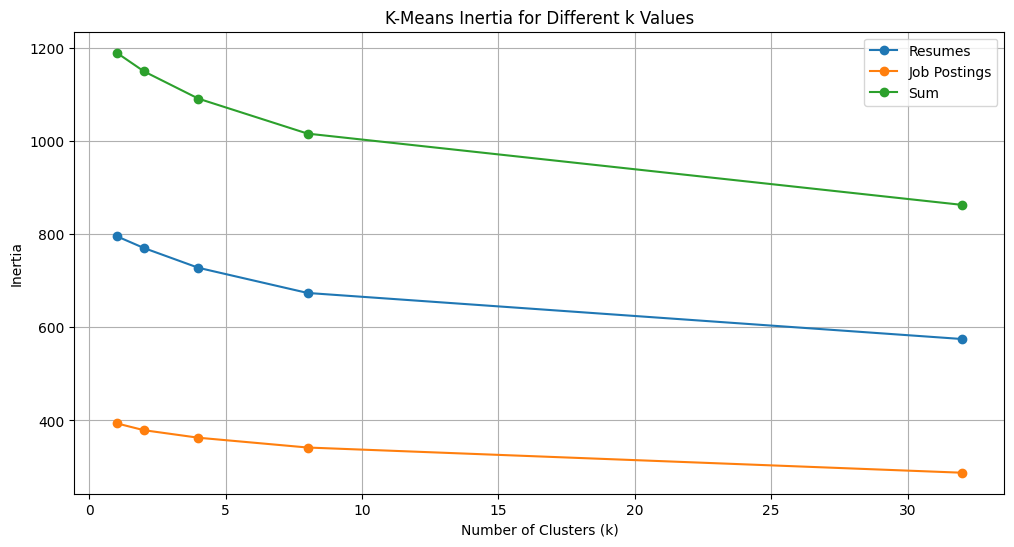

In [209]:
from sklearn.cluster import KMeans

def plot_kmeans_inertia_range(res_embeds, job_embeds, k_range):    
    resume_inertia = []
    job_posting_inertia = []
    sum_inertia = []
    for k in k_range:
        kmeans_resumes = KMeans(n_clusters=k, random_state=42)
        kmeans_resumes.fit(res_embeds)
        resume_inertia.append(kmeans_resumes.inertia_)
        
        kmeans_job_postings = KMeans(n_clusters=k, random_state=42)
        kmeans_job_postings.fit(job_embeds)
        job_posting_inertia.append(kmeans_job_postings.inertia_)

        sum_inertia.append(kmeans_resumes.inertia_+kmeans_job_postings.inertia_)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(k_range, resume_inertia, marker='o', label='Resumes')
    plt.plot(k_range, job_posting_inertia, marker='o', label='Job Postings')
    plt.plot(k_range, sum_inertia, marker='o', label='Sum')
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('K-Means Inertia for Different k Values')
    plt.legend()
    plt.grid(True)
    plt.show()

resumes_embeds = np.array(resumes_df['embedding'].tolist())
jobs_embeds = np.array(jobs_df['embedding'].tolist())
plot_kmeans_inertia_range(resumes_embeds, jobs_embeds, [1,2,4,8,32])

Through other tests, I found that this clustering lacked much semantic meaning and there was no clear elbow in the plot.

### Latent Dirichlet Analysis

Instead, we will use LDA analysis which is an NLP technique that extracts the key topics from a corpus of text. Below I have setup the framework and fed the resumes/jobs into the algorithm.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text: str) -> str:
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(tokens)

processed_jobs = [preprocess_text(text) for text in jobs_df['job_description']]
processed_resumes = [preprocess_text(text) for text in resumes_df['Resume_str']]

jobs_vectorizer = CountVectorizer()
resumes_vectorizer = CountVectorizer()

jobs_texts_vec = jobs_vectorizer.fit_transform(processed_jobs)
resumes_texts_vec = resumes_vectorizer.fit_transform(processed_resumes)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jasam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jasam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We can now visualise the different topics that the resumes/jobs sort themselves into. I have added colours for each topic. As we can see there seems to be some kind of shared structure in the way the resumes / jobs categorise themselves into their key topics.

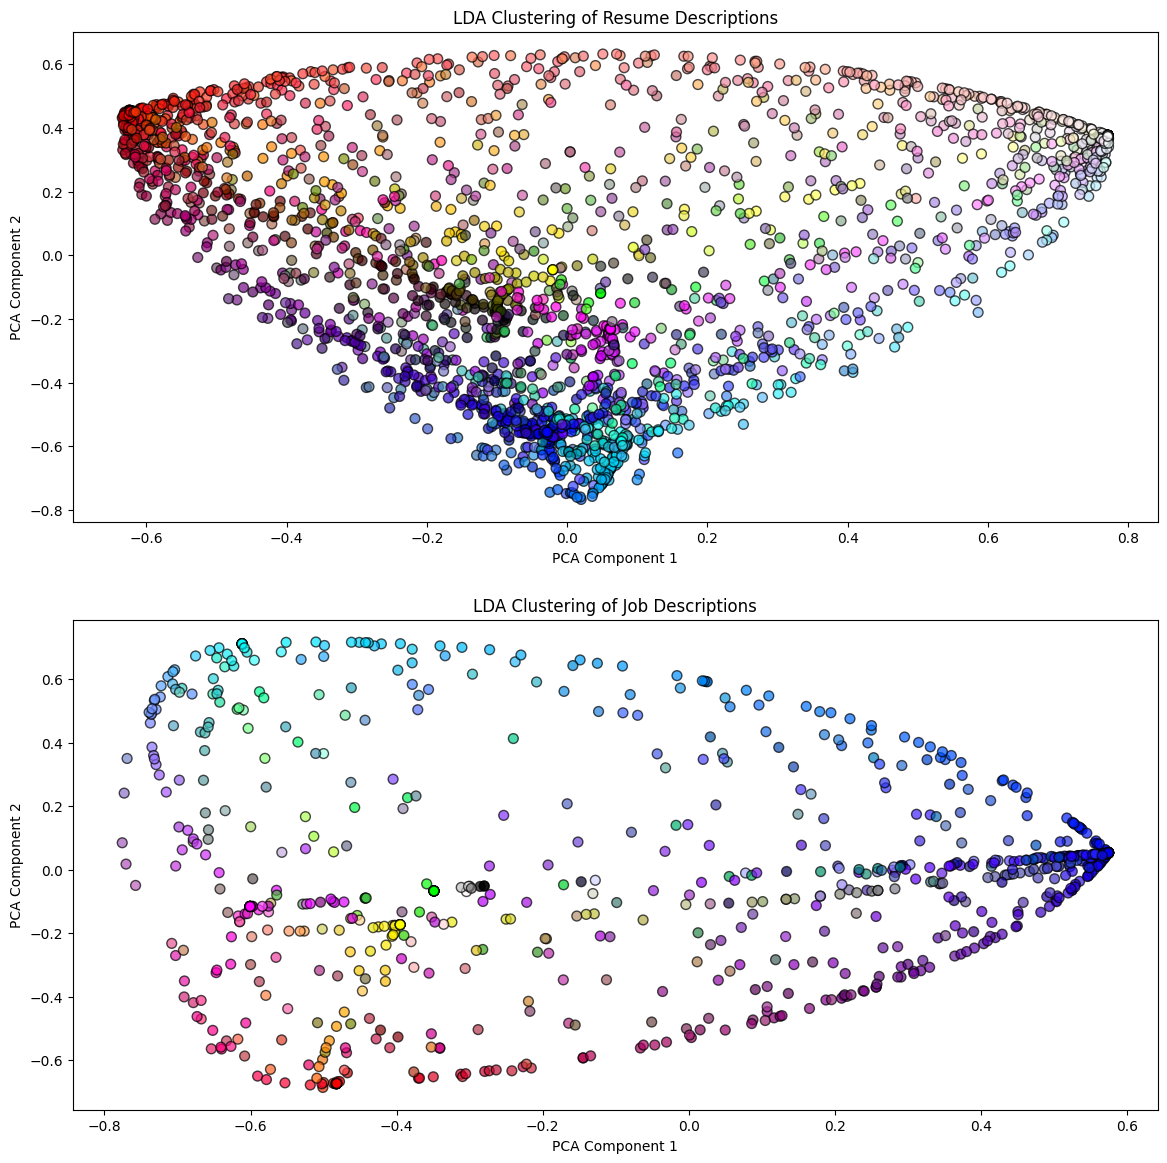

In [223]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from matplotlib.colors import to_hex
from sklearn.metrics import euclidean_distances

n_comp = 8

resumes_lda = LatentDirichletAllocation(n_components=n_comp, random_state=42)
resumes_lda.fit(resumes_texts_vec)

jobs_lda = LatentDirichletAllocation(n_components=n_comp, random_state=42)
jobs_lda.fit(jobs_texts_vec)

resumes_topic_distribution = resumes_lda.transform(resumes_texts_vec)
resumes_cluster_centers = resumes_lda.components_ / resumes_lda.components_.sum(axis=1)[:,np.newaxis]
jobs_topic_distribution = jobs_lda.transform(jobs_texts_vec)
jobs_cluster_centers = jobs_lda.components_ / jobs_lda.components_.sum(axis=1)[:, np.newaxis]

resumes_normalizer = Normalizer()
resumes_normalized = resumes_normalizer.fit_transform(resumes_topic_distribution)
jobs_normalizer = Normalizer()
jobs_normalized = jobs_normalizer.fit_transform(jobs_topic_distribution)

resumes_pca = PCA(n_components=2)
resumes_pca_fit = resumes_pca.fit_transform(resumes_normalized)
jobs_pca = PCA(n_components=2)
jobs_pca_fit = jobs_pca.fit_transform(jobs_normalized)

resumes_distances = euclidean_distances(resumes_texts_vec, resumes_cluster_centers)
jobs_distances = euclidean_distances(jobs_texts_vec, jobs_cluster_centers)

colormap = np.array([[0,0,0],[0,0,1],[0,1,0],[1,0,0],[0,1,1],[1,1,0],[1,0,1],[1,1,1]])
def get_color(topic_dist): return np.array([topic_dist]) @ colormap

resumes_colors = [to_hex(get_color(resumes_topic_distribution[i])) for i in range(len(resumes_pca_fit))]
jobs_colors = [to_hex(get_color(jobs_topic_distribution[i])) for i in range(len(jobs_pca_fit))]

plt.figure(figsize=(14, 14))

plt.subplot(2,1,1)
plt.scatter(resumes_pca_fit[:, 0], resumes_pca_fit[:, 1], c=resumes_colors, edgecolor='k', alpha=0.7, marker='o', s=50)
plt.title('LDA Clustering of Resume Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(2,1,2)
plt.scatter(jobs_pca_fit[:, 0], jobs_pca_fit[:, 1], c=jobs_colors, edgecolor='k', alpha=0.7, marker='o', s=50)
plt.title('LDA Clustering of Job Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

Let's print out each of the topics in text for the resume/job clusters.

In [210]:
from scipy.spatial import procrustes

def get_top_keywords(lda_model, vectorizer, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_keywords_idx = topic.argsort()[-n_words:][::-1]
        topic_keywords[f'Topic {topic_idx}'] = keywords[top_keywords_idx]
    return topic_keywords

resumes_keywords = get_top_keywords(resumes_lda, resumes_vectorizer)
jobs_keywords = get_top_keywords(jobs_lda, jobs_vectorizer)

print("Resume keywords:", resumes_keywords)
print("Jobs keywords:", jobs_keywords)

Resume keywords: {'Topic 0': array(['state', 'company', 'city', 'financial', 'management', 'project',
       'accounting', 'name', 'construction', 'analysis'], dtype=object), 'Topic 1': array(['business', 'company', 'management', 'marketing', 'sales', 'city',
       'state', 'development', 'name', 'new'], dtype=object), 'Topic 2': array(['state', 'city', 'company', 'name', 'students', 'education',
       'skills', 'training', 'school', 'student'], dtype=object), 'Topic 3': array(['customer', 'state', 'company', 'city', 'service', 'management',
       'name', 'sales', 'skills', 'customers'], dtype=object)}
Jobs keywords: {'Topic 0': array(['experience', 'software', 'systems', 'work', 'system',
       'development', 'network', 'security', 'applications', 'web'],
      dtype=object), 'Topic 1': array(['experience', 'team', 'business', 'work', 'management', 'skills',
       'marketing', 'ability', 'development', 'including'], dtype=object), 'Topic 2': array(['customer', 'work', 'customers'

We can now generate embeddings based on the keywords represented by each of the cluster keywords. So for each of the 8 topics listed for resumes/jobs, we will generate an embedding vector. Using this vector we can help gather a rough idea for how we should map on datapoint to another. 

In [224]:
def get_keyword_embeddings(keywords):
    embeddings = {}
    for topic, words in keywords.items():
        topic_embeddings = []
        for word in words:
            topic_embeddings.append(get_embeddings([word], verbose=False)[0])
        if topic_embeddings:
            embeddings[topic] = np.mean(topic_embeddings, axis=0)
    return embeddings

resumes_topics_embeddings = get_keyword_embeddings(resumes_keywords)
jobs_topics_embeddings = get_keyword_embeddings(jobs_keywords)

def normalize_embeddings(embeddings):
    normalized_embeddings = {}
    for topic, embedding in embeddings.items():
        norm = np.linalg.norm(embedding)
        normalized_embeddings[topic] = embedding / norm
    return normalized_embeddings

resumes_topics_embeddings_norm = normalize_embeddings(resumes_topics_embeddings)
jobs_topics_embeddings_norm = normalize_embeddings(jobs_topics_embeddings)

print(resumes_topics_embeddings_norm)
print(jobs_topics_embeddings_norm)

{'Topic 0': array([ 0.02140898,  0.00487155,  0.0520204 , ..., -0.03165759,
        0.02005188,  0.00212742]), 'Topic 1': array([ 0.01644197,  0.00694827,  0.05018274, ..., -0.02714048,
        0.01340191,  0.00292056]), 'Topic 2': array([ 0.01152377, -0.01774091,  0.04601956, ..., -0.01986398,
       -0.00721867, -0.01289922]), 'Topic 3': array([ 0.03319291, -0.00201296,  0.03569405, ..., -0.02455113,
        0.01730242, -0.00408826])}
{'Topic 0': array([ 0.0043987 ,  0.01203833,  0.05403694, ..., -0.03045199,
       -0.00469079, -0.01030346]), 'Topic 1': array([ 0.02651635,  0.02049374,  0.07142459, ..., -0.02442614,
        0.00485645,  0.00167199]), 'Topic 2': array([ 0.02246397, -0.00201856,  0.02554688, ..., -0.01679717,
        0.01658782, -0.00373914]), 'Topic 3': array([ 0.01965428,  0.01463804,  0.01510902, ..., -0.01903601,
       -0.004815  , -0.0116815 ])}


### Autoencoder
Now we will use an auto-encoder to encode each job description/resume. This will produce a dense representation of the embeddings. We will then append for each resume/job encoding, the topic distributions associated with each encoding and its LDA clusters worked out previously. Using this encoding (with cluster info appended) we will perform a General Procrustes Analysis, to figure out the best way to map the data.

In [225]:
resumes_dataset = create_dataset(resumes_embeds)
resumes_models = []
resumes_auto_losses = []

jobs_dataset = create_dataset(jobs_embeds)
jobs_models = []
jobs_auto_losses = []


input_dim = 1536
hidden_dims = [8,16,32,64]

for hidden_dim in hidden_dims:
    print(f"Training autoencoders with dim {hidden_dim}")
    
    resumes_auto, resumes_auto_loss = mini_train(resumes_dataset, input_dim, hidden_dim)
    jobs_auto, jobs_auto_loss = mini_train(jobs_dataset, input_dim, hidden_dim) # I shortened the dataset, change this above not here!
    
    resumes_models.append(resumes_auto)
    resumes_auto_losses.append(resumes_auto_loss)

    jobs_models.append(jobs_auto)
    jobs_auto_losses.append(jobs_auto_loss)

Training autoencoders with dim 8
Training autoencoders with dim 16
Training autoencoders with dim 32
Training autoencoders with dim 64


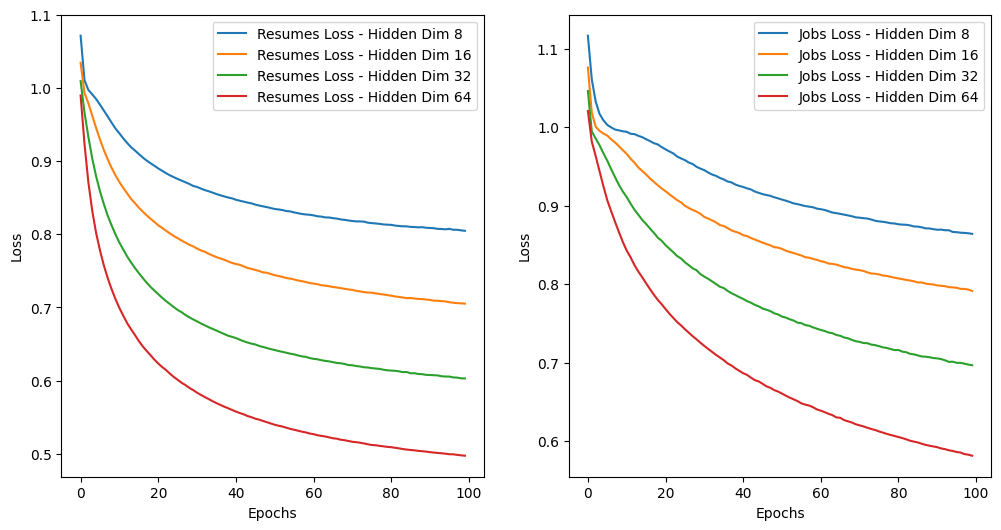

In [226]:
plt.figure(figsize=(12,6))
for i, hidden_dim in enumerate(hidden_dims):
    plt.subplot(1,2,1)
    plt.plot(resumes_auto_losses[i], label=f'Resumes Loss - Hidden Dim {hidden_dim}')
    plt.subplot(1,2,2)
    plt.plot(jobs_auto_losses[i], label=f'Jobs Loss - Hidden Dim {hidden_dim}')    

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.show()

In [227]:
resumes_model = resumes_models[3]
resumes_enc = [resumes_model.encode(ivec).detach().numpy() for ivec in [resumes_dataset[ind][0] for ind in range(len(resumes_dataset))]]
resumes_enc = np.array(resumes_enc)

jobs_model = jobs_models[3]
jobs_enc = [jobs_model.encode(ivec).detach().numpy() for ivec in [jobs_dataset[ind][0] for ind in range(len(jobs_dataset))]]
jobs_enc = np.array(jobs_enc)

resumes_df['encoding'] = resumes_enc.tolist()
jobs_df['encoding'] = jobs_enc.tolist()

resumes_df['trans-encoding'] = np.concatenate([np.array(resumes_enc), resumes_topic_distribution], axis=1).tolist()
jobs_df['trans-encoding'] = np.concatenate([np.array(jobs_enc), jobs_topic_distribution], axis=1).tolist()

### General Procrustes Analysis

Now we will use the transformed encodings to map data from one set onto another. We will use a General Procrustes Analysis to find the best orientation/scaling/reflection to map the data.

In [332]:
def apply_gpa(matrix1, matrix2):
    min_size = min(matrix1.shape[0], matrix2.shape[0])
    matrix1 = matrix1[:min_size]
    matrix2 = matrix2[:min_size]
    matrix1_transposed, matrix2_transposed, _ = procrustes(matrix1, matrix2)
    return matrix1_transposed, matrix2_transposed

resumes_enc_mat = np.array(resumes_df['trans-encoding'].tolist())
jobs_enc_mat = np.array(jobs_df['trans-encoding'].tolist())

aligned_resumes_enc_mat, aligned_jobs_enc_mat = apply_gpa(
    resumes_enc_mat, 
    jobs_enc_mat)

pca = PCA(n_components=2)
resumes_enc_mat_pca = pca.fit_transform(resumes_enc_mat)
jobs_enc_mat_pca = pca.transform(jobs_enc_mat)

pca = PCA(n_components=2)
aligned_resumes_enc_mat_pca = pca.fit_transform(aligned_resumes_enc_mat)
aligned_jobs_enc_mat_pca = pca.transform(aligned_jobs_enc_mat)

We can now create a mapping based on distance between the aligned resumes/jobs, this is graphed below.

C:\Users\Jasam\AppData\Local\Temp\ipykernel_14232\522035795.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([aligned_resumes_enc_mat_pca[i, 0], aligned_jobs_enc_mat_pca[idx, 0]],


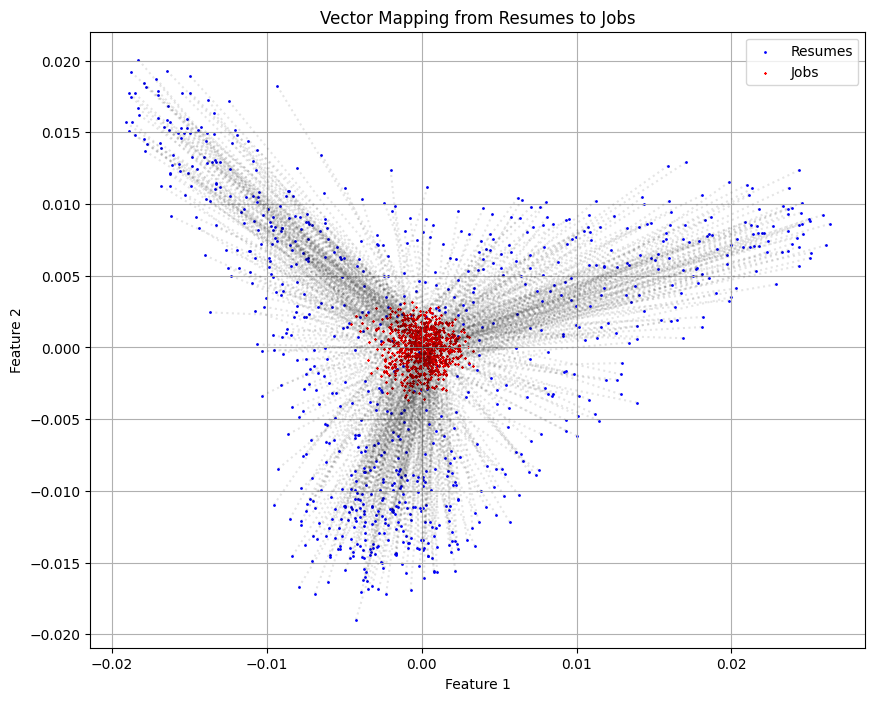

In [334]:
from scipy.optimize import linear_sum_assignment

transformed_distances = euclidean_distances(aligned_resumes_enc_mat, aligned_jobs_enc_mat)
row_indices, col_indices = linear_sum_assignment(transformed_distances)

#position = resume_iloc, element = job
mapped_indices = col_indices

plt.figure(figsize=(10, 8))
plt.scatter(aligned_resumes_enc_mat_pca[:, 0], aligned_resumes_enc_mat_pca[:, 1], c='blue', label='Resumes', marker='o', s=1)
plt.scatter(aligned_jobs_enc_mat_pca[:, 0], aligned_jobs_enc_mat_pca[:, 1], c='red', label='Jobs', marker='x', s=1)

for i, idx in enumerate(mapped_indices):
    plt.plot([aligned_resumes_enc_mat_pca[i, 0], aligned_jobs_enc_mat_pca[idx, 0]], 
             [aligned_resumes_enc_mat_pca[i, 1], aligned_jobs_enc_mat_pca[idx, 1]], 
             'k--', linestyle='dotted', alpha=0.1)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Vector Mapping from Resumes to Jobs')
plt.legend()
plt.grid(True)

plt.show()

Below is an example resume being mapped to a job

In [338]:
ex_res = 249
ex_job = mapped_indices[ex_res]

print(f"Mapped resume #{ex_res} to job #{ex_job} \n\n")
print("RESUME:", resumes_df.iloc[ex_res].Resume_str[:1000])
print("\n\nMAPPED TO \n\n")
print("JOB POST:", jobs_df.iloc[ex_job].job_description[:1000])

Mapped resume #249 to job #254 


RESUME:     Objective    To obtain a position in the information technology, personnel development, or computer science field to help manage, develop, and support projects and individuals.           ADJUNCT INFORMATION TECHNOLOGY INSTRUCTOR       Experience      Adjunct Information Technology Instructor   01/2014   to   Current     Company Name   City  ,   State       Taught courses concerning the Python, Visual Basic, and C# programming languages.  Sat on CIT advisory board committee to improve and recruit students to the KCTCS CIT program.          Information Technology Instructor and School Technology Coordinator   11/2011   to   Current     Company Name   City  ,   State       Responsible for meeting the educational needs of high school students.Instructed classes concerning A+ certification, Cisco certification, web design, programming, game design, and help desk.  Taught programming courses concerning C#, Python, Java, and Javascript programming

For the most part the tool works fine, but occasionally gets confused as in the following exmple below where it confuses a HR generalists's resume for the job posting of someone who wants to build an HR app!

In [330]:
ex_res = 20
ex_job = mapped_indices[ex_res]

print(f"Mapped #{ex_res} resume to #{ex_job} job")
print(resumes_df.iloc[ex_res].Resume_str[:1000])
print("MAPPED TO ")
print(jobs_df.iloc[ex_job].job_description[:1000])

Mapped #20 resume to #95 job
         HR GENERALIST           Summary    Young, dedicated and focused office administrative assistant who excels at prioritizing, completing multiple tasks simultaneously and following through to achieve project goals. Seeking a role of increased responsibility and authority. SKILL HIGHLIGHTS Microsoft Office proficiency	Self-directed Excel spreadsheets	Professional and mature Meticulous attention to detail	Strong interpersonal skills Results-oriented	Keen understanding of grammar Strong problem solver	Dedicated team player Executive presentation development	Ability to maintain confidentiality ACCOMPLISHMENTS Received a merit raise for strong attention to detail, exemplary customer service and team-player attitude (Extra Mile Award-2009, 2011) Increased office organization by developing more efficient filing system and customer database protocols.           Experience      HR Generalist    April 2013   to   October 2013     Company Name   －   City  ,   S

### Summary
So to obtain this mapping, we first created performed an LDA clustering, by recognising which semantic topics appeared in both datasets. In this LDA clustering, we assigned to each resume/job a distribution of how well each LDA cluster fit to that specific resume/job. We then created encodings for each piece of data. We then appeneded to each encoding the LDA topic distributions. Then we performed a GPA on the encodings to find the best alignment of the encodings in nd space. We then map the encodings to one another using the euclidean distance between them. All that is left, is to relate each aligned row back to its index, to find the overall mappings. 

In this example, I did not tell the data how to align itself and because of the structures of the different LDA topics, the data automatically aligned jobs to well fit resumes. The automatic alignment will be dependent on the structure of the data sent in, so be wary of this. If we send in only jobs for tech roles and resumes of historians of cousre we will have a bad fit, this algorithm relies on the idea that the input data has some hidden structures to be exploited.

### Extensions
If we wanted to go one step further and tell the algorithm how to align the data, this should be possible. All we need to do is to take the cosine distance between some "query string" and the data, and use that in place of the automatic LDA topic distributions. We can repeat this querying for however nuanced a connection we want. LDA just automates this for us, so we don't have to tell the data what we want to map by. So for example, if we want to location of job to resume, we can take the cosine distance of the embedding("location of job" and the embeddings of all jobs and append that as an extra dimension onto the encodings. Of course for every extra dimension we add to one set of encodings (jobs) we need to add to the other set (resumes), this extra dimension can be empty if we want. The appended dimensions just strengthen whatever metrics we wish to map by.

We could also run this algorithm recursively to gain further nauance into the connections. This should be easy to implement, espcially with the LDA version of clustering. 

A final nice property of this mapping algorithm is the way we can weight the importance of certain properties. So if we do choose to manually say property x of this data should be used, then we are free to assign a number to how important this property is in relation to the other properties when we append it to the encodings. 


#### Author: Jasamrit Singh Rahala 
Hope this notebook provides some help